# 접속자 수 증감에 영향을 끼치는 변수 파악

## 목적

- 회귀분석을 통해 접속자 수에 영향을 미치는 핵심 변수를 식별
- 주요 변수(가격, 할인, 리뷰, SNS 노출 등)를 기반으로 오버워치2에 적용 시 접속자 증가 가능성 예측

## 사용 파일

- 최종_스팀게임정보12차.csv
- 분석 대상: 우수 게임 3종 (RDR2, Marvel Rivals, PUBG)

## 1. 데이터 전처리

In [99]:
import pandas as pd
df = pd.read_csv('최종_스팀게임정보12차.csv')

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3351 entries, 0 to 3350
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           3351 non-null   int64  
 1   appid                3351 non-null   int64  
 2   game_name            3351 non-null   object 
 3   genre                3351 non-null   object 
 4   price                3351 non-null   int64  
 5   release_date         3351 non-null   object 
 6   developer            3351 non-null   object 
 7   publisher            3351 non-null   object 
 8   user_reaction        3351 non-null   object 
 9   DLC여부                3351 non-null   float64
 10  all_reviews          3351 non-null   float64
 11  positive_reviews     3351 non-null   float64
 12  negative_reviews     3351 non-null   float64
 13  sns_channels         3351 non-null   object 
 14  features             3351 non-null   object 
 15  bundle               3351 non-null   f

In [101]:
df.duplicated().sum()

np.int64(0)

In [102]:
df.columns

Index(['Unnamed: 0', 'appid', 'game_name', 'genre', 'price', 'release_date',
       'developer', 'publisher', 'user_reaction', 'DLC여부', 'all_reviews',
       'positive_reviews', 'negative_reviews', 'sns_channels', 'features',
       'bundle', 'awards', 'controller_support', 'interface_languages',
       'subtitle_languages', 'voice_languages', 'discount', 'discount_start',
       'discount_finish', 'avg_monthly_avg', 'main_genre', 'genre_list',
       'avg_mean', 'positive_ratio', 'sns_count'],
      dtype='object')

### a. 열 정제
1. 삭제
- Unnamed
- appid
- game_name
- positive_reviews : 다중공선성 떄문에 삭제
- negative_reviews : 다중공선성 떄문에 삭제
- discount_start
- discount_finish
- interface_languages
- subtitle_languages
- voice_languages
- features
- genre
- genre_list

2. 열 생성
- discount_days : 할인 기간(몇 일이나 할인을 했는지)
- interface_cnt : 인터페이스 언어 갯수
- subtitle_cnt : 자막 언어 갯수
- voice_cnt : 음성 언어 갯수

In [103]:
import pandas as pd
from datetime import datetime

# 오늘 날짜
today = pd.Timestamp.today().normalize()  # 시분초 제거

# 날짜 변환 함수
def calc_discount_days(row):
    start, end = row['discount_start'], row['discount_finish']
    
    # 1. 할인 없음
    if start == 'x' or end == 'x':
        return 0
    
    # 2. 시작 날짜 파싱
    try:
        start_date = pd.to_datetime(start, format="%Y.%m.%d", errors='coerce')
    except:
        return 0
    
    # 3. 종료 날짜 파싱
    if end == '~':  # 종료일이 '~'이면 오늘 날짜까지 계산
        end_date = today
    else:
        try:
            end_date = pd.to_datetime(end, format="%Y.%m.%d", errors='coerce')
        except:
            return 0
    
    # 날짜 차이 계산 (NaT 방지)
    if pd.isna(start_date) or pd.isna(end_date):
        return 0
    
    return (end_date - start_date).days

# 새로운 열 생성
df['discount_days'] = df.apply(calc_discount_days, axis=1)
df['discount_days']

0          0
1          0
2       1576
3        742
4       2940
        ... 
3346    2940
3347    3042
3348    1561
3349    2940
3350       0
Name: discount_days, Length: 3351, dtype: int64

In [104]:
df['discount_days'].value_counts()

discount_days
0       1374
2940      96
3021      37
14        29
7         25
        ... 
538        1
2107       1
878        1
997        1
104        1
Name: count, Length: 1145, dtype: int64

In [105]:
# 문자열을 세어 개수로 변환하는 함수
def count_languages(val):
    if val == "x":
        return 0
    return len([lang.strip() for lang in val.split(",") if lang.strip()])

# 새로운 cnt 열 생성
df['interface_cnt'] = df['interface_languages'].apply(count_languages)
df['subtitle_cnt'] = df['subtitle_languages'].apply(count_languages)
df['voice_cnt'] = df['voice_languages'].apply(count_languages)

In [106]:
df[['interface_cnt', 'subtitle_cnt', 'voice_cnt']].value_counts()

interface_cnt  subtitle_cnt  voice_cnt
1              0             0            293
               1             1            237
               0             1            197
2              0             0             67
5              0             0             64
                                         ... 
0              1             0              1
1              22            1              1
               8             1              1
               5             1              1
               4             2              1
Name: count, Length: 410, dtype: int64

In [107]:
# 게임 이름열은 혹시나 하는 상황을 대비해 회귀분석 모델학습 전에 삭제 후 진행
# 여기선 일단 남겨놓고 진행

df.drop(['Unnamed: 0', 'appid', 'genre', 'positive_reviews', 'negative_reviews', 'discount_start',
       'discount_finish', 'interface_languages', 'subtitle_languages', 'voice_languages', 'features', 'genre_list'], axis=1, inplace=True)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3351 entries, 0 to 3350
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_name           3351 non-null   object 
 1   price               3351 non-null   int64  
 2   release_date        3351 non-null   object 
 3   developer           3351 non-null   object 
 4   publisher           3351 non-null   object 
 5   user_reaction       3351 non-null   object 
 6   DLC여부               3351 non-null   float64
 7   all_reviews         3351 non-null   float64
 8   sns_channels        3351 non-null   object 
 9   bundle              3351 non-null   float64
 10  awards              3351 non-null   float64
 11  controller_support  3351 non-null   object 
 12  discount            3351 non-null   float64
 13  avg_monthly_avg     3351 non-null   float64
 14  main_genre          3351 non-null   object 
 15  avg_mean            3351 non-null   float64
 16  positi

### b. 학습 전 데이터 처리

- 레이블링
    - user_reaction

- 원-핫 인코딩
    - sns_channels
    - controller_support
    - main_genre

- 타깃 인코딩
    - developer
    - publisher

- 스케일링
    - price
    - release_date : 숫자형태로 변환 후 스케일링 진행
    - all_reviews
    - discount
    - avg_monthly_avg
    - positive_ratio
    - sns_count
    - discount_days
    - interface_cnt
    - subtitle_cnt
    - voice_cnt

#### 레이블링
- user_reaction

In [109]:
# 매핑 딕셔너리 (0부터 시작, 강도 순서대로)
reaction_map = {
    "압도적으로 부정적": 1,
    "부정적": 2,
    "대체로 부정적": 3,
    "복합적": 4,
    "없음": 0,
    "긍정적": 5,
    "대체로 긍정적": 6,
    "매우 긍정적": 7,
    "압도적으로 긍정적": 8
}

# 새로운 열 생성
df['user_reaction_label'] = df['user_reaction'].map(reaction_map)
df.drop('user_reaction', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3351 entries, 0 to 3350
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_name            3351 non-null   object 
 1   price                3351 non-null   int64  
 2   release_date         3351 non-null   object 
 3   developer            3351 non-null   object 
 4   publisher            3351 non-null   object 
 5   DLC여부                3351 non-null   float64
 6   all_reviews          3351 non-null   float64
 7   sns_channels         3351 non-null   object 
 8   bundle               3351 non-null   float64
 9   awards               3351 non-null   float64
 10  controller_support   3351 non-null   object 
 11  discount             3351 non-null   float64
 12  avg_monthly_avg      3351 non-null   float64
 13  main_genre           3351 non-null   object 
 14  avg_mean             3351 non-null   float64
 15  positive_ratio       3351 non-null   f

#### 원-핫 인코딩
- sns_channels
- controller_support

In [111]:
import pandas as pd

# 문자열을 리스트로 변환 (운영안함 포함, x만 제외)
def split_values(x):
    if x == "x":
        return []
    return [i.strip() for i in x.split(",")]

# sns_channels와 controller_support 리스트화
df['sns_list'] = df['sns_channels'].apply(split_values)
df['controller_list'] = df['controller_support'].apply(split_values)

# (1) sns_channels 고유값 추출 후 원핫 인코딩
sns_unique = sorted(set([v for sublist in df['sns_list'] for v in sublist]))
for col in sns_unique:
    df[f"sns_{col}"] = df['sns_list'].apply(lambda x: 1 if col in x else 0)

# (2) controller_support 고유값 추출 후 원핫 인코딩
ctrl_unique = sorted(set([v for sublist in df['controller_list'] for v in sublist]))
for col in ctrl_unique:
    df[f"ctrl_{col}"] = df['controller_list'].apply(lambda x: 1 if col in x else 0)

# 원본 열 제거 (main_genre는 그대로 남김)
df.drop(['sns_channels', 'controller_support', 'sns_list', 'controller_list'], axis=1, inplace=True)

In [112]:
df

,game_name,price,release_date,developer,publisher,DLC여부,all_reviews,bundle,awards,discount,...,sns_운영안함,ctrl_Controller Required?,ctrl_DualSense Controllers,ctrl_DualSense Controllers (USB Only),ctrl_DualShock Controllers,ctrl_DualShock Controllers (USB Only),ctrl_PlayStation Controllers,ctrl_Steam Input API?,ctrl_Support for other devices is not known,ctrl_Xbox Controllers
0,GUILTY GEAR -STRIVE-,19950,2021년 06월 11일,Arc System Works,Arc System Works,1.0,60509.0,1.0,1.0,0.0,...,1,0,0,0,0,0,1,0,0,1
1,Magic: The Gathering Arena,0,2023년 05월 24일,Wizards of the Coast LLC,Wizards of the Coast LLC,0.0,21203.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,EZ2ON REBOOT : R,44800,2022년 04월 14일,"Neonovice Co., Ltd., SQUARE PIXELS","Neonovice Co., Ltd.",1.0,5916.0,1.0,0.0,47.0,...,0,0,0,1,0,1,0,0,0,1
3,Sons Of The Forest,32000,2024년 02월 23일,Endnight Games Ltd,Newnight,0.0,264345.0,1.0,0.0,66.0,...,1,0,0,0,0,0,1,0,0,1
4,Left 4 Dead 2,11000,2009년 11월 17일,Valve,Valve,0.0,0.0,0.0,0.0,90.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,Tom Clancy's Ghost Recon® Desert Siege™,5500,2008년 07월 15일,Red Storm Entertainment,Ubisoft,0.0,155.0,1.0,0.0,75.0,...,0,0,0,0,0,0,0,0,0,0
3347,Frontlines™: Fuel of War™,0,2008년 03월 01일,Kaos Studios,THQ Nordic,0.0,1014.0,1.0,0.0,75.0,...,0,0,0,0,0,0,0,0,0,0
3348,PuzzleQuest: Challenge of the Warlords,10500,2008년 01월 29일,Infinite Interactive,"D3Publisher of America, Inc.",0.0,1082.0,1.0,0.0,90.0,...,1,0,0,0,0,0,0,0,0,0
3349,Lost Planet™: Extreme Condition,18800,2007년 06월 27일,"CAPCOM Co., Ltd.",Capcom,0.0,1990.0,1.0,0.0,80.0,...,0,0,0,0,0,0,0,0,1,1


#### 타깃 인코딩
- developer
- publisher
- main_genre

In [114]:
import pandas as pd

# 예시: 타깃 컬럼 = 'avg_mean'
target_col = 'avg_mean'  # 실제 타깃 컬럼명으로 변경

# developer 타깃 인코딩
developer_mean = df.groupby('developer')[target_col].mean()
df['developer_te'] = df['developer'].map(developer_mean)

# publisher 타깃 인코딩
publisher_mean = df.groupby('publisher')[target_col].mean()
df['publisher_te'] = df['publisher'].map(publisher_mean)

# main_genre 타깃 인코딩
genre_mean = df.groupby('main_genre')[target_col].mean()
df['main_genre_te'] = df['main_genre'].map(genre_mean)

# 원본 컬럼 제거
df.drop(['developer', 'publisher', 'main_genre'], axis=1, inplace=True)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3351 entries, 0 to 3350
Data columns (total 56 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   game_name                                    3351 non-null   object 
 1   price                                        3351 non-null   int64  
 2   release_date                                 3351 non-null   object 
 3   DLC여부                                        3351 non-null   float64
 4   all_reviews                                  3351 non-null   float64
 5   bundle                                       3351 non-null   float64
 6   awards                                       3351 non-null   float64
 7   discount                                     3351 non-null   float64
 8   avg_monthly_avg                              3351 non-null   float64
 9   avg_mean                                     3351 non-null   float64
 10  

#### 스케일링
- price
- release_date : 숫자형태로 변환 후 스케일링 진행
- all_reviews
- discount
- avg_monthly_avg
- positive_ratio
- sns_count
- discount_days
- interface_cnt
- subtitle_cnt
- voice_cnt
- user_reaction_label
- developer_te
- publisher_te
- main_genre_te

In [116]:
import pandas as pd
import re

def release_date_to_int(date_str):
    if pd.isna(date_str) or date_str.strip() == "":
        return 0  # 결측 처리
    
    # 년도 추출
    year_match = re.search(r"(\d{4})년", date_str)
    year = year_match.group(1) if year_match else "0000"
    
    # 월 추출
    month_match = re.search(r"(\d{1,2})월", date_str)
    month = month_match.group(1).zfill(2) if month_match else "00"
    
    # 일 추출
    day_match = re.search(r"(\d{1,2})일", date_str)
    day = day_match.group(1).zfill(2) if day_match else "00"
    
    return int(year + month + day)

# 적용
df['release_date_int'] = df['release_date'].apply(release_date_to_int)
df.drop('release_date', axis=1, inplace=True)
df['release_date_int']

0       20210611
1       20230524
2       20220414
3       20240223
4       20091117
          ...   
3346    20080715
3347    20080301
3348    20080129
3349    20070627
3350    20061014
Name: release_date_int, Length: 3351, dtype: int64

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 스케일링할 열 리스트
scale_cols = [
    'price', 'release_date_int', 'all_reviews', 'discount', 'avg_monthly_avg', 
    'positive_ratio', 'sns_count', 'discount_days', 
    'interface_cnt', 'subtitle_cnt', 'voice_cnt', 
    'user_reaction_label', 'developer_te', 'publisher_te', 'main_genre_te']

# 스케일러 초기화
scaler = StandardScaler()

# 스케일링 적용
df_scaled = df.copy()
df_scaled[scale_cols] = scaler.fit_transform(df_scaled[scale_cols])
df_scaled

,game_name,price,DLC여부,all_reviews,bundle,awards,discount,avg_monthly_avg,avg_mean,positive_ratio,...,ctrl_DualShock Controllers,ctrl_DualShock Controllers (USB Only),ctrl_PlayStation Controllers,ctrl_Steam Input API?,ctrl_Support for other devices is not known,ctrl_Xbox Controllers,developer_te,publisher_te,main_genre_te,release_date_int
0,GUILTY GEAR -STRIVE-,0.419456,1.0,0.479439,1.0,1.0,-1.002718,0.126059,-110.441667,0.634055,...,0,0,1,0,0,1,-0.083921,-0.068144,-0.128150,0.061910
1,Magic: The Gathering Arena,-0.805237,0.0,0.052921,0.0,0.0,-1.002718,0.433651,295.483333,-0.847127,...,0,0,0,0,0,0,1.135172,1.191724,0.063074,0.079967
2,EZ2ON REBOOT : R,1.944950,1.0,-0.112961,1.0,0.0,0.383295,-0.080047,-3.841667,0.774628,...,0,1,0,0,0,1,-0.039601,-0.041574,-0.072485,0.070799
3,Sons Of The Forest,1.159182,0.0,2.691305,1.0,0.0,0.943598,0.887213,835.016667,0.618065,...,0,0,1,0,0,1,3.252701,3.414744,0.460036,0.088761
4,Left 4 Dead 2,-0.129968,0.0,-0.177157,0.0,0.0,1.651349,2.273960,-96.091667,-4.538321,...,0,0,0,0,0,0,-2.149226,-2.049459,-0.413121,-0.046447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,Tom Clancy's Ghost Recon® Desert Siege™,-0.467603,0.0,-0.175475,1.0,0.0,1.209005,-0.089858,0.000000,0.803065,...,0,0,0,0,0,0,-0.024524,0.138735,0.226252,-0.055879
3347,Frontlines™: Fuel of War™,-0.805237,0.0,-0.166154,1.0,0.0,1.209005,-0.089728,0.041667,-0.542761,...,0,0,0,0,0,0,-0.024360,-0.027078,0.226252,-0.056255
3348,PuzzleQuest: Challenge of the Warlords,-0.160662,0.0,-0.165416,1.0,0.0,1.651349,-0.088669,0.100000,0.589952,...,0,0,0,0,0,0,-0.024327,-0.025974,-0.068710,-0.056411
3349,Lost Planet™: Extreme Condition,0.348859,0.0,-0.155563,1.0,0.0,1.356453,-0.089087,0.033333,0.247587,...,0,0,0,0,1,1,-0.393140,-0.018903,0.226252,-0.065027


In [118]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3351 entries, 0 to 3350
Data columns (total 56 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   game_name                                    3351 non-null   object 
 1   price                                        3351 non-null   float64
 2   DLC여부                                        3351 non-null   float64
 3   all_reviews                                  3351 non-null   float64
 4   bundle                                       3351 non-null   float64
 5   awards                                       3351 non-null   float64
 6   discount                                     3351 non-null   float64
 7   avg_monthly_avg                              3351 non-null   float64
 8   avg_mean                                     3351 non-null   float64
 9   positive_ratio                               3351 non-null   float64
 10  

In [119]:
df_scaled.drop('game_name', axis=1, inplace=True)

## 2. 모델 교차검증
- 결정트리
- 랜덤포레스트
- 그라디언트 부스팅
- xg부스트
- 라이트GBM
- 캣부스트

In [120]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np

# 스케일링된 df, 타깃 컬럼
X = df_scaled.drop(columns=['avg_mean'])  # 타깃 제외
y = df_scaled['avg_mean']

# 모델 딕셔너리
models = {
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=200, n_jobs=-1, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=200, n_jobs=-1),
    "CatBoost": CatBoostRegressor(random_state=42, iterations=200, verbose=0)
}

# 5-폴드 교차검증
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    # 1️⃣ RMSE 계산
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-mse_scores)
    
    # 2️⃣ R² 계산
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    
    # 결과 저장
    cv_results[name] = {
        'RMSE Mean': rmse_scores.mean(),
        'RMSE Std': rmse_scores.std(),
        'R2 Mean': r2_scores.mean(),
        'R2 Std': r2_scores.std()
    }

# 결과 DataFrame으로 정리
cv_df = pd.DataFrame(cv_results).T
cv_df = cv_df.sort_values('RMSE Mean')  # RMSE 기준 정렬
cv_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 2680, number of used features: 47
[LightGBM] [Info] Start training from score 6.835354
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 2681, number of used features: 47
[LightGBM] [Info] Start training from score 3.415734
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

,RMSE Mean,RMSE Std,R2 Mean,R2 Std
GradientBoosting,229.334743,69.653527,0.464851,0.120940
CatBoost,231.872286,73.874819,0.457324,0.101779
RandomForest,235.180863,84.284867,0.441649,0.173578
LightGBM,243.570891,45.913497,0.369962,0.104483
XGBoost,265.736472,114.551265,0.279494,0.307790
DecisionTree,324.478718,65.262552,-0.116880,0.195991


- 그라디언트 부스팅이 RMSE와 R2 모두 가장 좋은 결과를 냄
- 캣부스트는 성능이 거의 유사하지만 폴드 간 편차가 커서 일부 데이터셋에서는 예측이 불안정했음
- 랜덤포레스트는 그라디언부스팅보다는 약간 낮은 성능이지만 안정적이긴 함
- LightGBM/ XGBoost는 오히려 성능이 떨어짐
- DecisionTree는 설명력이 거의 없음(R2가 음수)

## 3. 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GradientBoosting
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0]
}

gb = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X, y)
gb_best = gb_grid.best_estimator_

# RandomForest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X, y)
rf_best = rf_grid.best_estimator_

# CatBoost
cb_params = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

cb = CatBoostRegressor(random_state=42, verbose=0)
cb_grid = GridSearchCV(cb, cb_params, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
cb_grid.fit(X, y)
cb_best = cb_grid.best_estimator_

# 최적 하이퍼파라미터 확인
print("GradientBoosting best params:", gb_grid.best_params_)
print("RandomForest best params:", rf_grid.best_params_)
print("CatBoost best params:", cb_grid.best_params_)

# 최적 모델로 RMSE, R2 계산
def cv_scores(model, X, y, cv):
    from sklearn.model_selection import cross_val_score
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'))
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return rmse_scores.mean(), rmse_scores.std(), r2_scores.mean(), r2_scores.std()

print("GradientBoosting:", cv_scores(gb_best, X, y, kf))
print("RandomForest:", cv_scores(rf_best, X, y, kf))
print("CatBoost:", cv_scores(cb_best, X, y, kf))

GradientBoosting best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
RandomForest best params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
CatBoost best params: {'depth': 4, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
GradientBoosting: (np.float64(213.55327552799992), np.float64(77.03135734677579), np.float64(0.5398873380838237), np.float64(0.1430143058499602))
RandomForest: (np.float64(223.02133688743515), np.float64(81.8470200254263), np.float64(0.49408092398885817), np.float64(0.1724521639365902))
CatBoost: (np.float64(218.74550159249492), np.float64(74.99156521208306), np.float64(0.49412411570301984), np.float64(0.1715810447887037))


- 그라디언트 부스팅이 다시 한 번 가장 정확한 모델인 것으로 확인되었다.

## 4. 모델 학습 및 예측

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 데이터 분리
X = df_scaled.drop('avg_mean', axis=1)
y = df_scaled['avg_mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GradientBoosting 모델 생성 (튜닝된 하이퍼파라미터 적용)
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.7,
    random_state=42)

# 모델 학습
gb_model.fit(X_train, y_train)

# 예측
y_pred = gb_model.predict(X_test)

# 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"GradientBoosting RMSE: {rmse:.3f}")
print(f"GradientBoosting R²: {r2:.3f}")

GradientBoosting RMSE: 349.967
GradientBoosting R²: 0.354


## 5. 모델이 예측할 때 변수 중요도 시각화

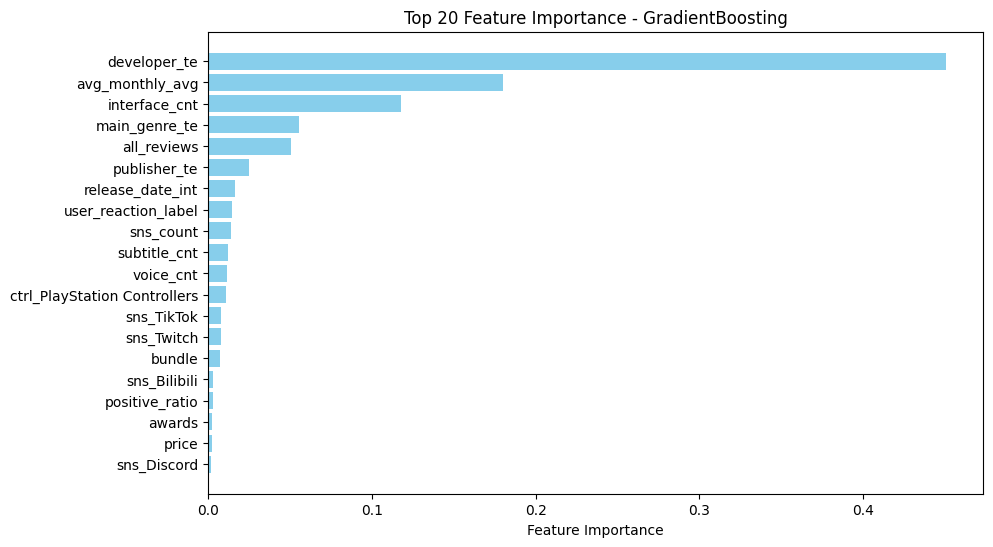

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# feature importance 추출
importance = gb_model.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importance})

# 중요도 기준 내림차순 정렬
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# 상위 20개만 선택
top_n = 20
top_feat = feat_imp.head(top_n)

# 시각화
plt.figure(figsize=(10,6))
plt.barh(top_feat['feature'][::-1], top_feat['importance'][::-1], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importance - GradientBoosting")
plt.show()

1. 개발사
    - 0.45정도로 개발사가 월 평균 유저 증감 수에 가장 큰 영향을 끼치고 있음
    - 유저들이 게임에 유입될 때는 개발사의 영향이 크다고 판단됨
    - 반대로 유저들이 빠져나갈 때도 개발사의 영향이 크다고 판단되는 부분

2. 월 평균 유저 수
    - 0.2 정도로 상대적으로 영향을 끼치는 편
    - 많은 사람들이 즐기는 인기 게임으로 유저들이 인식해 게임에 유입된다고 판단됨

3. 인터페이스 언어 수
    - 0.12정도로 지원되는 인터페이스 언어가 영향을 끼침
    - 단순히, 지원되는 언어가 많은 만큼 많은 나라의 사람들이 유입되거나 이탈될 가능성이 있지만
    - 지원되는 언어가 많을 수록 게임의 접근성이 올라가고 유저들이 유입될 가능성이 높음

4. 장르
    - 약 0.08로 장르가 영향을 끼치는 편
    - 고객들이 게임을 선택할 때 게임 이름, 장르, 가격은 맨 처음 보이는 것이기에 그만큼 선택에 있어 중요한 요소

5. 전체 리뷰 수
    - 약 0.06으로 영향을 끼치는 편
    - 월 평균 유저 수와 비슷한 결로 해당 게임의 인기 척도를 알아 볼 수 있는 지표

6. 그 외
    - 출판사 : 개발사와 비슷한 느낌이지만 유저들이 개발사에 더 높은 비중을 두고 게임에 관심을 가지는 경향이 있음
    - 유저 리액션 : 리뷰 수에 비해서 약한 영향을 끼치는 편
    - sns 채널 수 : 단순히 채널을 많이 운영하고 어떤 채널을 운영하는지가 중요한 것이 아닌 채널을 '어떻게' 운영할 것인지에 초점을 맞춰야 함
    - positive_ratio, price : 리뷰 긍정비율과 게임 가격은 월 평균 유저 증감수에 영향을 별로 끼치지 않는 편

- 변수 중 개발사, 장르는 변경이 불가능하기에 해당 열을 제외하고 회귀 학습 다시 진행

In [ ]:
df_scaled.drop(['developer_te', 'main_genre_te'], axis=1, inplace=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 데이터 준비
X = df_scaled.drop(columns=['avg_mean'])
y = df_scaled['avg_mean']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 모든 모델 정의
models = {
    # 기존 앙상블 / 부스팅
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, subsample=0.7, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_leaf=2, min_samples_split=2, random_state=42, n_jobs=-1),
    "CatBoost": CatBoostRegressor(depth=4, iterations=400, learning_rate=0.1, l2_leaf_reg=1, verbose=0, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1, verbosity=0),
    # 추가 앙상블
    "ExtraTrees": ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=300, random_state=42),
    # 선형 / 규제 회귀
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    # 신경망
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation='relu', max_iter=500, random_state=42)}

# 교차검증
cv_results = {}
for name, model in models.items():
    try:
        # RMSE 계산
        mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-mse_scores)
        # R² 계산
        r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
        # 결과 저장
        cv_results[name] = {
            'RMSE Mean': rmse_scores.mean(),
            'RMSE Std': rmse_scores.std(),
            'R2 Mean': r2_scores.mean(),
            'R2 Std': r2_scores.std()}
    except Exception as e:
        print(f"모델 {name} 에러: {e}")

# 결과 DataFrame으로 정리
cv_df = pd.DataFrame(cv_results).T
cv_df = cv_df.sort_values('RMSE Mean')
cv_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 2680, number of used features: 44
[LightGBM] [Info] Start training from score 6.835354
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 2681, number of used features: 44
[LightGBM] [Info] Start training from score 3.415734
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.903e+05, tolerance: 2.109e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.738e+04, tolerance: 2.816e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

,RMSE Mean,RMSE Std,R2 Mean,R2 Std
CatBoost,323.932886,74.138920,-0.107982,0.255917
ElasticNet,327.463946,71.292668,-0.117860,0.151407
RandomForest,328.236550,83.329560,-0.112942,0.166112
Ridge,329.027642,70.128492,-0.128520,0.125266
Lasso,329.476861,70.133722,-0.131333,0.119183
ExtraTrees,340.288829,83.190086,-0.198662,0.201610
LightGBM,356.529806,69.954029,-0.348456,0.280422
MLP,365.318757,64.356371,-0.459610,0.424271
GradientBoosting,372.381544,89.176258,-0.445413,0.291721
HistGradientBoosting,374.839938,68.573641,-0.516108,0.397626


- 모든 모델이 r2값이 음수로 모델이 제대로 예측을 못하는 상황
- 개발사와 장르를 제외하면 나머지 변수들만으로는 접속자 수를 예측하기 어렵다
    - 유저 유입은 게임의 콘텐츠 경쟁력(장르/브랜드력)에 훨씬 더 의존적이다

# 결론
1. 단순히 게임을 마케팅 하는 것이 아닌 블리자드 브랜드 마케팅이 필요한 시점
    - 게임의 월 평균 유저 증감수에 가장 많은 영향을 끼치는 것은 개발사, 월 평균 유저 수, 인터페이스 언어 수 순
    - 개발사, 퍼블리셔를 제외하고 머신러닝 학습시 머신이 제대로 학습하지 못함
    - 즉, 그만큼 개발사, 퍼블리셔가 많은 영향을 끼친다는 것

2. 마케팅 방향성
    - 많은 사람이 오버워치를 즐기고 있다는 활성 사용자 수에 대한 지표를 활용하는 것도 좋은 방법

3. SNS
    - 틱톡, 트위치, 빌리빌리가 영상 플랫폼이 월 평균 유저 증감수에 다른 채널보다 영향을 끼치는 편
    - 다만 트위치는 오버워치가 주최가 되어 영상을 스트리밍 하기보다는 스트리머들이 주최가 되는 편으로 인플루언서를 통한 마케팅 방법도 좋다고 판단됨
    - 틱톡, 빌리빌리는 동영상 플랫폼으로 해당 플랫폼에 집중하는 것도 방법
